<a href="https://colab.research.google.com/github/jagadeesh01032005/explainable-AI/blob/main/Assignment_2_2290.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)

In [ ]:
df = pd.read_csv("/content/online_shoppers_intention.csv")
print("Shape:", df.shape)
print(df.head())


Shape: (12330, 18)
   Administrative  Administrative_Duration  Informational  \
0               0                      0.0              0   
1               0                      0.0              0   
2               0                      0.0              0   
3               0                      0.0              0   
4               0                      0.0              0   

   Informational_Duration  ProductRelated  ProductRelated_Duration  \
0                     0.0               1                 0.000000   
1                     0.0               2                64.000000   
2                     0.0               1                 0.000000   
3                     0.0               2                 2.666667   
4                     0.0              10               627.500000   

   BounceRates  ExitRates  PageValues  SpecialDay Month  OperatingSystems  \
0         0.20       0.20         0.0         0.0   Feb                 1   
1         0.00       0.10         0.0  

In [ ]:
target = "Revenue"
df[target] = df[target].astype(int)  # Convert to int
df = df.drop_duplicates()            # Drop duplicates

print("Missing values:\n", df.isnull().sum())


Missing values:
 Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64


In [ ]:
# Identify categorical & numeric columns
categorical_cols = df.select_dtypes(include=["object", "bool"]).columns.tolist()
categorical_cols = [c for c in categorical_cols if c != target]
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c != target]

print("Numeric Features:", numeric_cols)
print("Categorical Features:", categorical_cols)


Numeric Features: ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'OperatingSystems', 'Browser', 'Region', 'TrafficType']
Categorical Features: ['Month', 'VisitorType', 'Weekend']


In [ ]:

X = df.drop(columns=[target])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:

numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

In [ ]:

clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(n_estimators=200, random_state=42))
])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]


In [ ]:

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_proba)

print("\nEvaluation Metrics:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"ROC-AUC:   {roc:.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))



Evaluation Metrics:
Accuracy:  0.9025
Precision: 0.7432
Recall:    0.5759
F1-score:  0.6490
ROC-AUC:   0.9262
Confusion Matrix:
 [[1983   76]
 [ 162  220]]


100%|===================| 4878/4882 [10:41<00:00]       

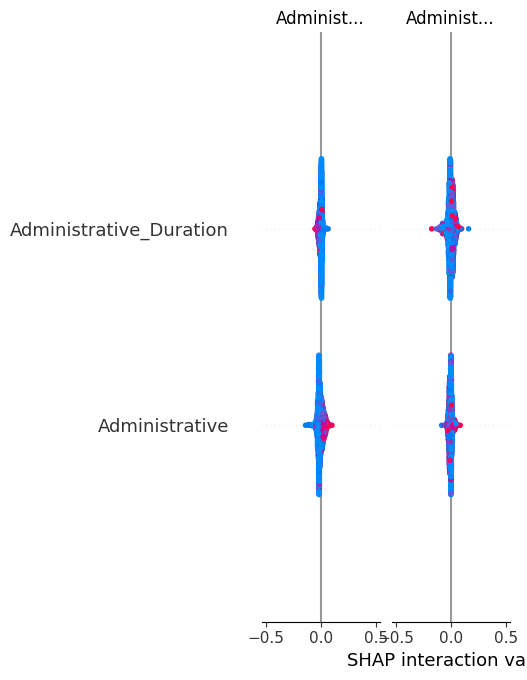

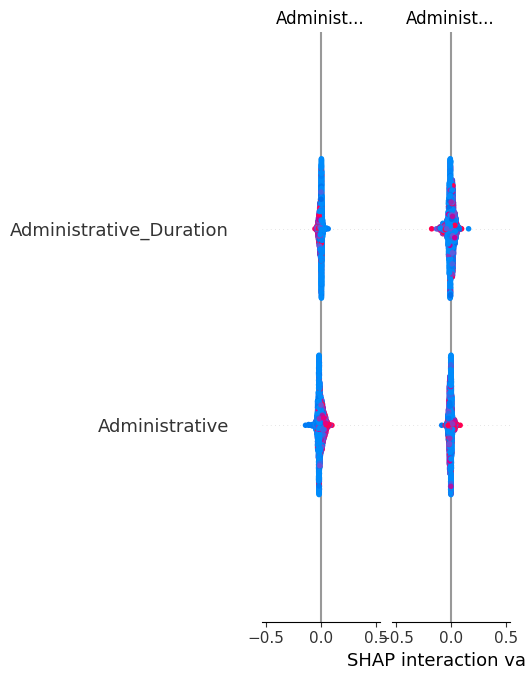

In [ ]:

# Extract trained RF and transformed data
rf_model = clf.named_steps["model"]
X_train_transformed = clf.named_steps["preprocessor"].transform(X_train)
X_test_transformed  = clf.named_steps["preprocessor"].transform(X_test)

# Get feature names from ColumnTransformer
ohe = clf.named_steps["preprocessor"].named_transformers_["cat"]
ohe_features = ohe.get_feature_names_out(categorical_cols)
all_features = numeric_cols + list(ohe_features)

# Convert transformed arrays to DataFrames
X_train_df = pd.DataFrame(
    X_train_transformed.toarray() if hasattr(X_train_transformed, "toarray") else X_train_transformed,
    columns=all_features
)
X_test_df = pd.DataFrame(
    X_test_transformed.toarray() if hasattr(X_test_transformed, "toarray") else X_test_transformed,
    columns=all_features
)
# SHAP Analysis (fixed)
# -------------------------
# Build explainer with background = train set
explainer = shap.Explainer(rf_model, X_train_df)

# Get SHAP values (disable additivity check to avoid floating errors)
shap_values = explainer(X_test_df, check_additivity=False)

# -------------------------
# Global explanation
# -------------------------
shap.summary_plot(shap_values, X_test_df, plot_type="bar")
shap.summary_plot(shap_values, X_test_df)